# CNN - Modelling (Binary + MOG + Embedded TL)

# 1. Load Images

In [1]:
import tensorflow as tf
%matplotlib inline

print(tf.__version__)

2.4.2


In [2]:
! nvidia-smi

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Thu Aug 12 07:49:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%    

Due to insufficient memory, we have no choice but import all images into a 130 $\times$ 130 smaller arrays.

In [3]:
SRC_BINARY = "/home/ubuntu/crack/MOG-Binary/"

from crack_utils import load_binary_dataset

x_train, x_test, y_train, y_test = load_binary_dataset(SRC_BINARY, (130, 130), color_mode="rgb")

# 2. Pretrain Model as Embedded Feature Extractor 

Only use the deep layers (roughly the first 1/3 of the whole network) from pre-trained model to learn elementary features. Then we build our model (VGG blocks) upon that to learn deeper features. 

Since we dont have a large number of samples, the number VGG blocks to add is arbitrarily selected as 2 and each block has two convolutional layer, one max pooling layer and one dropout layer.

We've discarded 2 pretrained model used in standalone TL:

* **VGG19**: we've found it not trainable after adding customized VGG blocks.

* **NASNetLarge**: the network structure is not linear, thus hard to be embedded customized VGG blocks.

## 2.1 ResNet152V2

In [4]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout
from crack_utils import vgg_block, classification_block, binary_compile

def ResNet152V2_Embedded(dropout=True):
    # create pre-trained model instance
    model = ResNet152V2(include_top=False, input_shape=(130, 130, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # arbitrarily select output layer from pre-trained model
    out = model.get_layer('conv3_block1_preact_relu').output
     # add vgg module
    layer = vgg_block(out, 64, 2)
    if dropout:
        layer = Dropout(0.3)(layer)
    # add vgg module
    layer = vgg_block(layer, 128, 2)
    if dropout:
        layer = Dropout(0.4)(layer)
    # add classification block
    layer = classification_block(layer, 16)
    # create model
    model = Model(inputs=model.inputs, outputs=layer)
    return model

# create model instance
model = ResNet152V2_Embedded()
binary_compile(model, 0.0005, 0.9)
model.layers[-3].output_shape

Extension horovod.torch has not been built: /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2021-08-12 07:49:40.572 ip-172-31-5-51:20761 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-08-12 07:49:40.596 ip-172-31-5-51:20761 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


(None, 2048)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input as pre_resnet_v2

datagen_train = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    preprocessing_function=pre_resnet_v2)

datagen_test = ImageDataGenerator(preprocessing_function=pre_resnet_v2)

train_it = datagen_train.flow(x_train, y_train, batch_size=64, seed=100)
test_it = datagen_test.flow(x_test, y_test, batch_size=64, seed=100)

In [6]:
%%time

histories = dict()

histories["Bi_MOG_TL2_ResNet152V2"] = model.fit(x=train_it, steps_per_epoch=len(train_it),
              validation_data=test_it, validation_steps=len(test_it), epochs=30, verbose=0).history

CPU times: user 1min 45s, sys: 25.1 s, total: 2min 10s
Wall time: 1min 38s


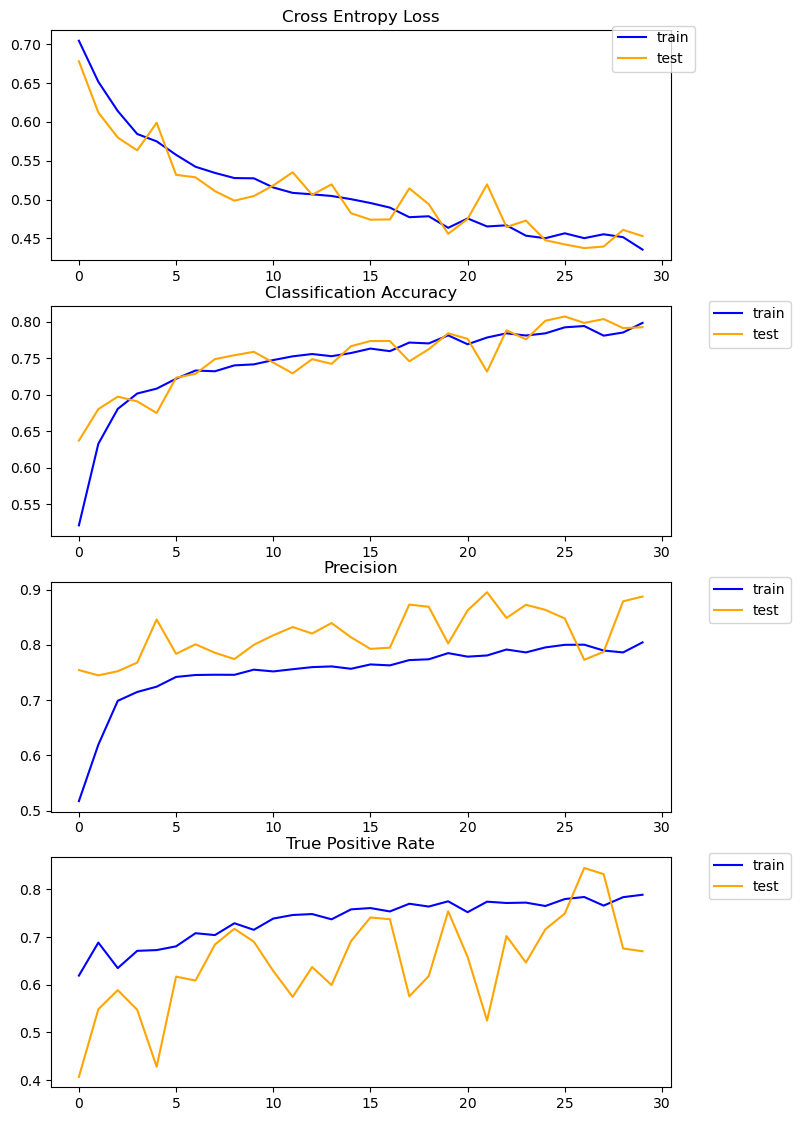

In [7]:
from crack_utils import summarize_diagnostics_binary

summarize_diagnostics_binary(histories["Bi_MOG_TL2_ResNet152V2"], "model_plot/Bi_MOG_TL2_ResNet152V2.png")

In [8]:
from crack_utils import show_result

show_result(model, test_it)
del model

Test loss: 0.45
Test Accuracy: 0.79
Test Precision: 0.89
Test True Positive Rate: 0.67


## 2.2 DenseNet201

In [9]:
from tensorflow.keras.applications import DenseNet201

def DenseNet201_Embedded(dropout=True):
    # create pre-trained model instance
    model = DenseNet201(include_top=False, input_shape=(130, 130, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # arbitrarily select output layer from pre-trained model
    out = model.get_layer('pool2_pool').output
    # add vgg module
    layer = vgg_block(out, 64, 2)
    if dropout:
        layer = Dropout(0.3)(layer)
    layer = vgg_block(layer, 128, 2)
    if dropout:
        layer = Dropout(0.4)(layer)
    # add classification block
    layer = classification_block(layer, 16)
    # create model
    model = Model(inputs=model.inputs, outputs=layer)
    return model

# create model instance
model = DenseNet201_Embedded()
binary_compile(model, 0.0005, 0.9)
model.layers[-3].output_shape

(None, 2048)

In [10]:
from tensorflow.keras.applications.densenet import preprocess_input as pre_densenet

datagen_train = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    preprocessing_function=pre_densenet)

datagen_test = ImageDataGenerator(preprocessing_function=pre_densenet)

train_it = datagen_train.flow(x_train, y_train, batch_size=64, seed=100)
test_it = datagen_test.flow(x_test, y_test, batch_size=64, seed=100)

In [11]:
%%time

histories["Bi_MOG_TL2_DenseNet201"] = model.fit(x=train_it, steps_per_epoch=len(train_it),
              validation_data=test_it, validation_steps=len(test_it), epochs=30, verbose=0).history

CPU times: user 2min 2s, sys: 26.2 s, total: 2min 28s
Wall time: 1min 59s


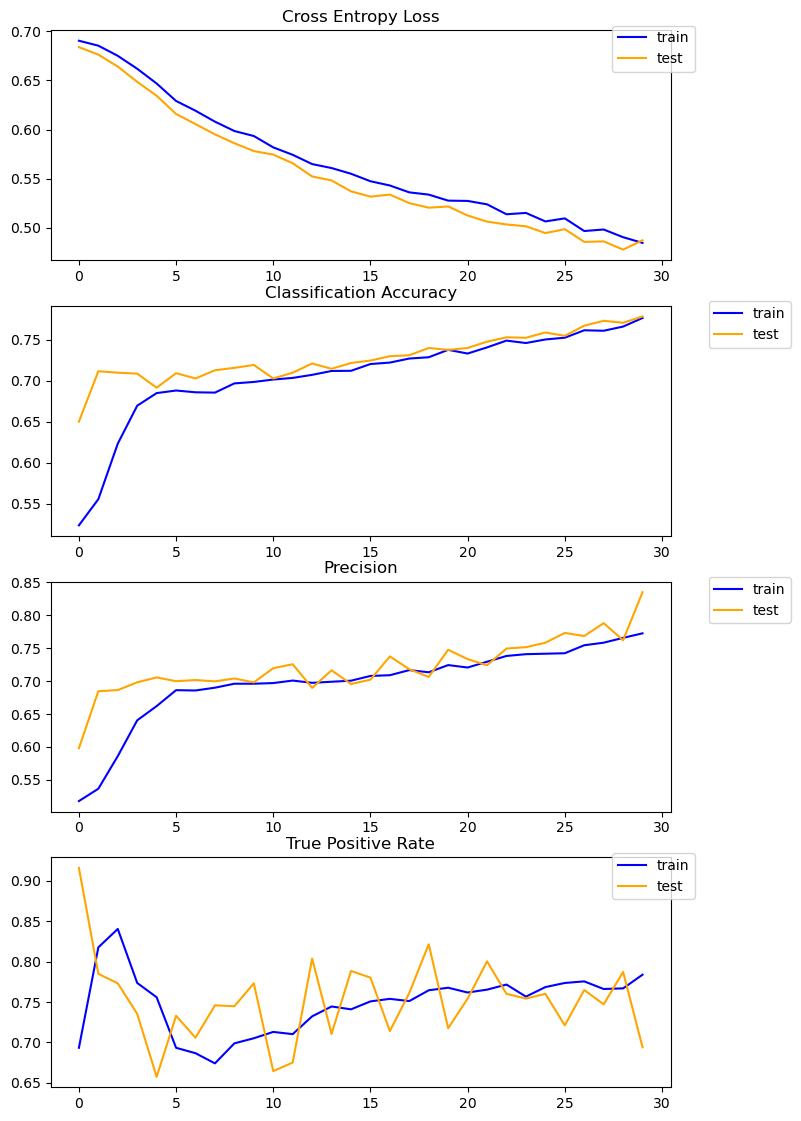

In [12]:
summarize_diagnostics_binary(histories["Bi_MOG_TL2_DenseNet201"], "model_plot/Bi_MOG_TL2_DenseNet201.png")

In [13]:
show_result(model, test_it)
del model

Test loss: 0.49
Test Accuracy: 0.78
Test Precision: 0.83
Test True Positive Rate: 0.69


## 2.3 InceptionV3

In [14]:
from tensorflow.keras.applications import InceptionV3

def InceptionV3_Embedded(dropout=True):
    # create pre-trained model instance
    model = InceptionV3(include_top=False, input_shape=(130, 130, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # arbitrarily select output layer from pre-trained model
    out = model.get_layer("mixed2").output 
    # add vgg module
    layer = vgg_block(out, 64, 2)
    if Dropout:
        layer = Dropout(0.3)(layer)
    layer = vgg_block(layer, 128, 2)
    if Dropout:
        layer = Dropout(0.4)(layer)
    # add classification block
    layer = classification_block(layer, 16)
    # create model
    model = Model(inputs=model.inputs, outputs=layer)
    return model

# create model instance
model = InceptionV3_Embedded()
binary_compile(model, 0.0005, 0.9)
model.layers[-3].output_shape

(None, 1152)

In [15]:
from tensorflow.keras.applications.inception_v3 import preprocess_input as pre_inception_v3

datagen_train = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    preprocessing_function=pre_inception_v3)

datagen_test = ImageDataGenerator(preprocessing_function=pre_inception_v3)

train_it = datagen_train.flow(x_train, y_train, batch_size=64, seed=100)
test_it = datagen_test.flow(x_test, y_test, batch_size=64, seed=100)

In [16]:
%%time

histories["Bi_MOG_TL2_InceptionV3"] = model.fit(x=train_it, steps_per_epoch=len(train_it),
              validation_data=test_it, validation_steps=len(test_it), epochs=30, verbose=0).history

CPU times: user 1min 39s, sys: 24.1 s, total: 2min 3s
Wall time: 1min 20s


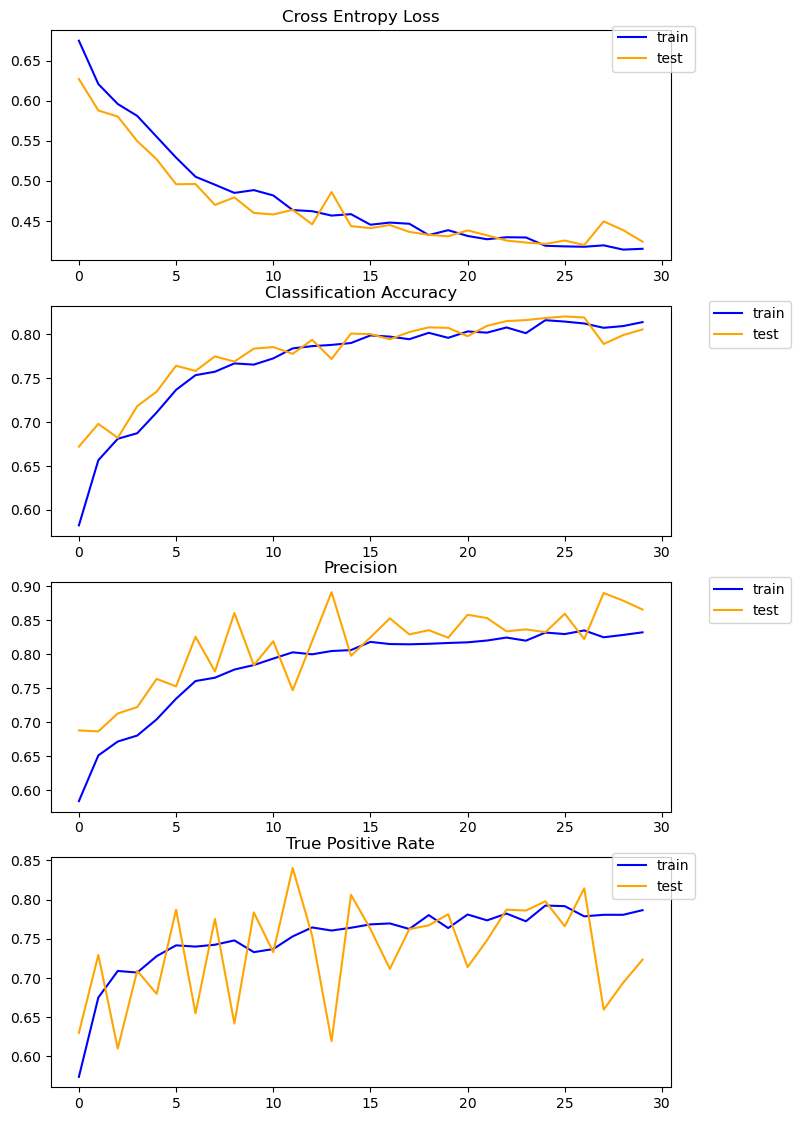

In [17]:
summarize_diagnostics_binary(histories["Bi_MOG_TL2_InceptionV3"], "model_plot/Bi_MOG_TL2_InceptionV3.png")

In [18]:
show_result(model, test_it)
del model

Test loss: 0.42
Test Accuracy: 0.81
Test Precision: 0.87
Test True Positive Rate: 0.72


## 2.4 InceptionResNetV2

In [19]:
from tensorflow.keras.applications import InceptionResNetV2

def InceptionResNetV2_Embedded(dropout=True):
    # create pre-trained model instance
    model = InceptionResNetV2(include_top=False, input_shape=(130, 130, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # arbitrarily select output layer from pre-trained model
    out = model.get_layer('block35_6').output
    # add vgg module
    layer = vgg_block(out, 64, 2)
    if Dropout:
        layer = Dropout(0.3)(layer)
    layer = vgg_block(layer, 128, 2)
    if Dropout:
        layer = Dropout(0.4)(layer)
    # add classification block
    layer = classification_block(layer, 16)
    # create model
    model = Model(inputs=model.inputs, outputs=layer)
    return model

# create model instance
model = InceptionResNetV2_Embedded()
binary_compile(model, 0.0005, 0.9)
model.layers[-3].output_shape

(None, 1152)

In [20]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as pre_inception_resnet_v2

datagen_train = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    preprocessing_function=pre_inception_resnet_v2)

datagen_test = ImageDataGenerator(preprocessing_function=pre_inception_resnet_v2)

train_it = datagen_train.flow(x_train, y_train, batch_size=64, seed=100)
test_it = datagen_test.flow(x_test, y_test, batch_size=64, seed=100)

In [21]:
%%time

histories["Bi_MOG_TL2_InceptionResNetV2"] = model.fit(x=train_it, steps_per_epoch=len(train_it),
              validation_data=test_it, validation_steps=len(test_it), epochs=30, verbose=0).history

CPU times: user 1min 59s, sys: 20.7 s, total: 2min 19s
Wall time: 1min 40s


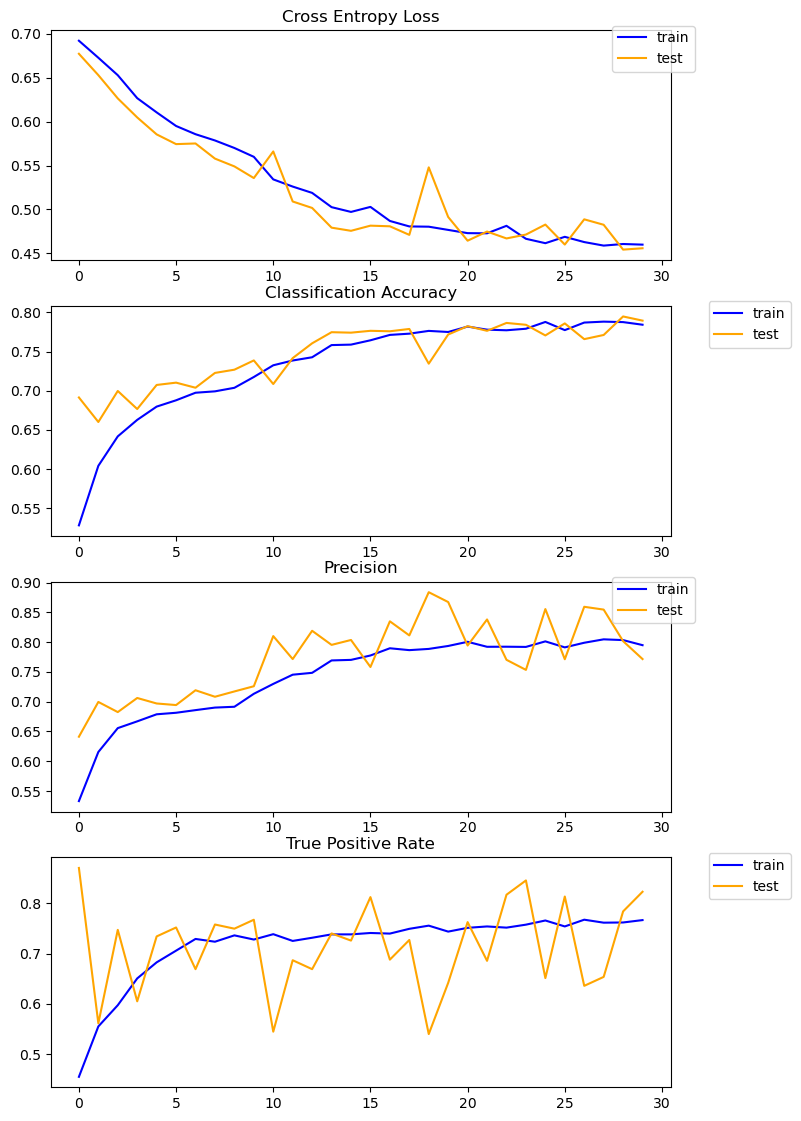

In [22]:
summarize_diagnostics_binary(histories["Bi_MOG_TL2_InceptionResNetV2"], 
                             "model_plot/Bi_MOG_TL2_InceptionResNetV2.png")

In [23]:
show_result(model, test_it)
del model

Test loss: 0.46
Test Accuracy: 0.79
Test Precision: 0.77
Test True Positive Rate: 0.82


## 2.5 Xception

In [24]:
from tensorflow.keras.applications import Xception

def Xception_Embedded(dropout=True):
    # create pre-trained model instance
    model = Xception(include_top=False, input_shape=(130, 130, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # arbitrarily select output layer from pre-trained model
    out = model.layers[25].output
    # add vgg module
    layer = vgg_block(out, 64, 2)
    if Dropout:
        layer = Dropout(0.3)(layer)
    layer = vgg_block(layer, 128, 2)
    if Dropout:
        layer = Dropout(0.4)(layer)
    # add classification block
    layer = classification_block(layer, 16)
    # create model
    model = Model(inputs=model.inputs, outputs=layer)
    return model

# create model instance
model = Xception_Embedded()
binary_compile(model, 0.0005, 0.9)
model.layers[-3].output_shape

(None, 2048)

In [25]:
from tensorflow.keras.applications.xception import preprocess_input as pre_xception

datagen_train = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    preprocessing_function=pre_xception)

datagen_test = ImageDataGenerator(preprocessing_function=pre_xception)

train_it = datagen_train.flow(x_train, y_train, batch_size=64, seed=100)
test_it = datagen_test.flow(x_test, y_test, batch_size=64, seed=100)

In [26]:
%%time

histories["Bi_MOG_TL2_Xception"] = model.fit(x=train_it, steps_per_epoch=len(train_it),
              validation_data=test_it, validation_steps=len(test_it), epochs=30, verbose=0).history

CPU times: user 1min 44s, sys: 22.3 s, total: 2min 7s
Wall time: 1min 40s


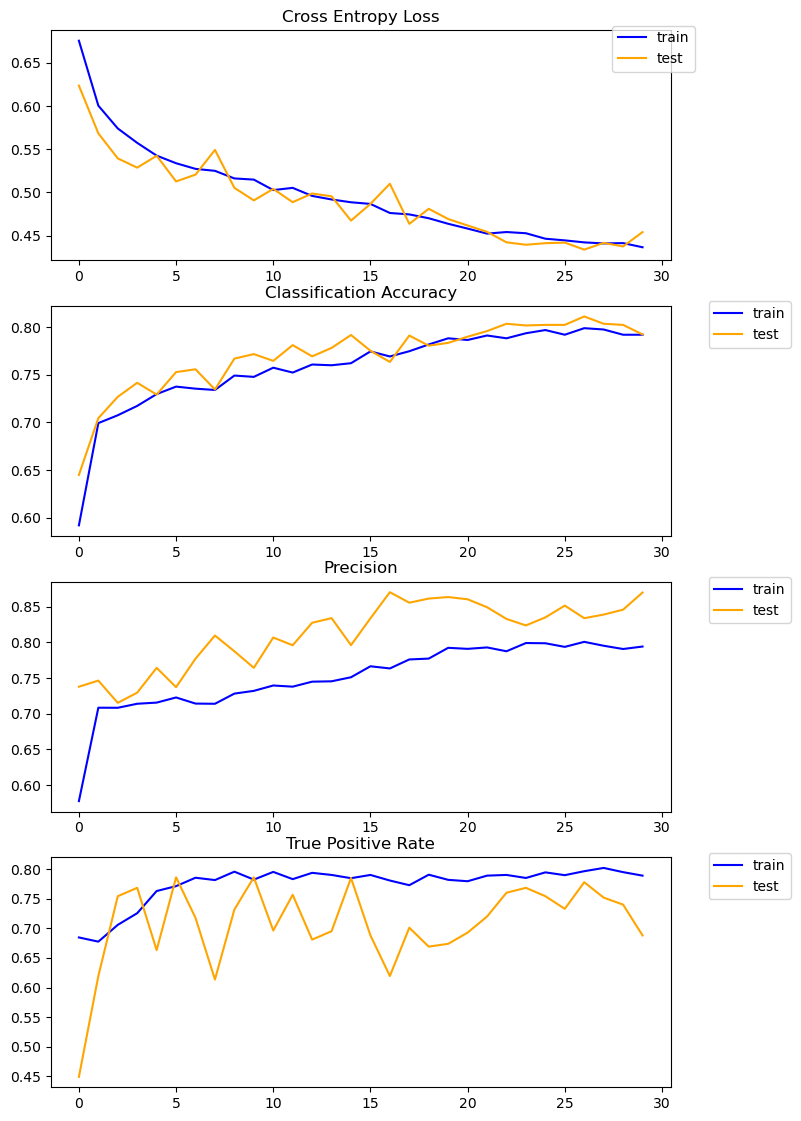

In [27]:
summarize_diagnostics_binary(histories["Bi_MOG_TL2_Xception"], "model_plot/Bi_MOG_TL2_Xception.png")

In [28]:
show_result(model, test_it)
del model

Test loss: 0.45
Test Accuracy: 0.79
Test Precision: 0.87
Test True Positive Rate: 0.69


# 3. Summary

30th epoch result:

In [29]:
from crack_utils import get_percentile_result

result_30 = get_percentile_result(histories, 25)
result_30.round(2)

,Bi_MOG_TL2_ResNet152V2,Bi_MOG_TL2_DenseNet201,Bi_MOG_TL2_InceptionV3,Bi_MOG_TL2_InceptionResNetV2,Bi_MOG_TL2_Xception
Loss,0.45,0.49,0.42,0.48,0.44
Accuracy,0.80,0.76,0.82,0.77,0.80
Precision,0.86,0.76,0.83,0.86,0.84
TPR,0.72,0.76,0.80,0.65,0.75


21-30 epochs (Average):

In [30]:
from crack_utils import get_avg_result

avg_result = get_avg_result(histories, start_epoch=21)
avg_result.round(2)

,Bi_MOG_TL2_ResNet152V2,Bi_MOG_TL2_DenseNet201,Bi_MOG_TL2_InceptionV3,Bi_MOG_TL2_InceptionResNetV2,Bi_MOG_TL2_Xception
Loss,0.46,0.49,0.43,0.47,0.44
Accuracy,0.79,0.76,0.81,0.78,0.80
Precision,0.85,0.77,0.85,0.81,0.84
TPR,0.71,0.75,0.75,0.75,0.74


Compare each model:

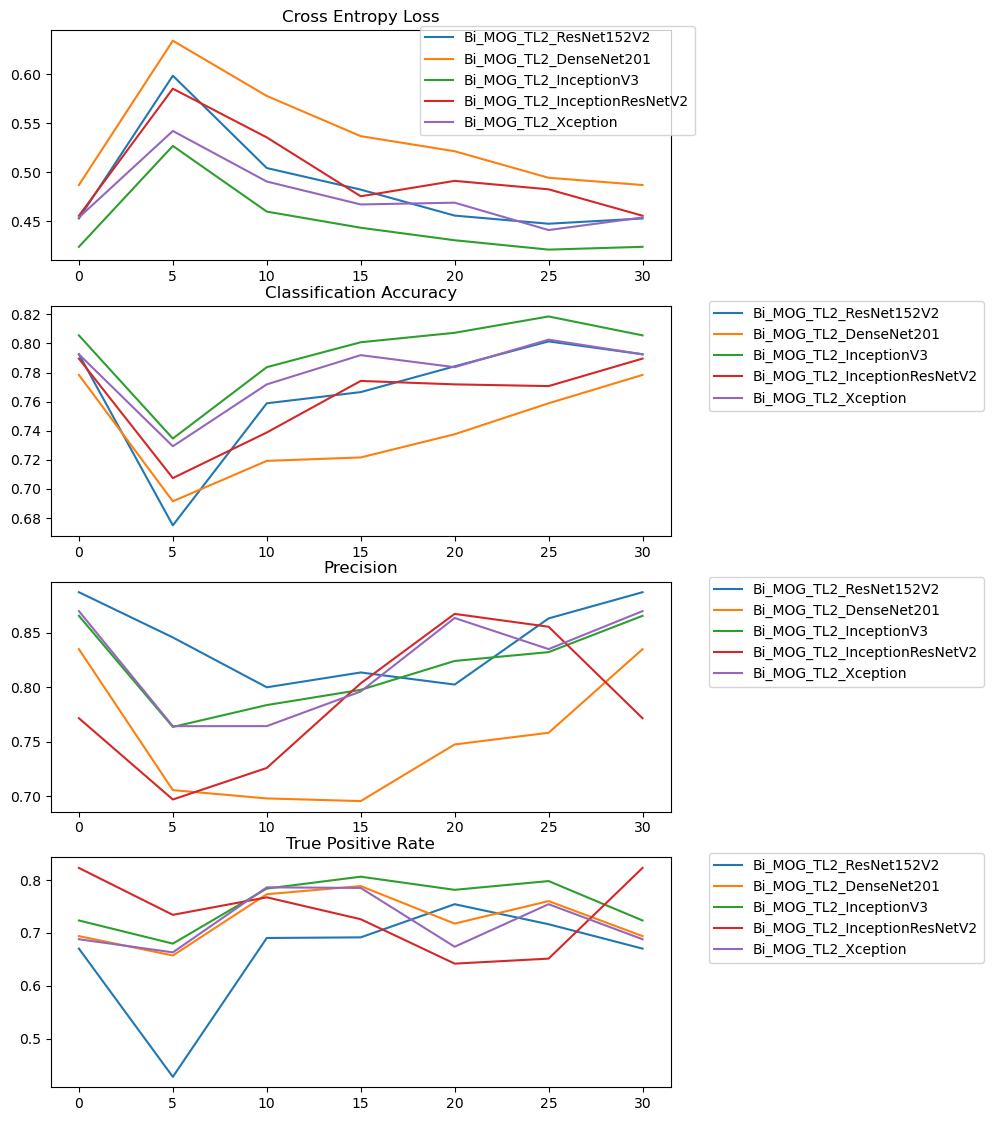

In [31]:
from crack_utils import compare_all_result

compare_all_result(histories, filename="model_plot/Compare_Bi_MOG_Embedded_TF.png", end=30, step=5)

Save epochs history:

In [32]:
from crack_utils import save_history

save_history(histories, folder="epochs_history")